You’re a Machine Learning Engineer at a fast-paced AI startup building intelligent assistant products powered by large language models. Your team is evaluating Meta’s LLaMA model as a potential foundation model for your internal applications.

In this phase of the project, your goal is to run a fine-tuning proof of concept (PoC). You’ll start by preparing a dataset relevant to your use case, tokenizing it, and creating a dataloader. Then, you’ll serve the base LLaMA model using huggingface transformer to establish a performance baseline.

Once the baseline is established, you’ll fine-tune the model using methods like LoRA or other resource-efficient techniques. Finally, you’ll re-evaluate the model to measure accuracy improvements using task-specific metrics (e.g., BLEU, ROUGE etc.), and reflect on how fine-tuning affects model performance.

**The T4 GPU on Google Colab should be sufficient for this MP. You don’t need to purchase Colab Pro, as the T4 is available for free for a limited time every day. However, avoid wasting GPU time when not running code, as the free tier can run out quickly.**



# Step 0: set up environment

In [1]:
!pip install datasets
!pip install transformers==4.46.2
!pip install absl-py nltk rouge-score
!pip install evaluate
!pip install bert_score
!pip install peft
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

To download the LLaMA model, obtain an access token from Hugging Face and log in using the following code:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Step 1: Prepare the data loader for batch generation (10pt)

In [ ]:
# load dataset
from datasets import Dataset, load_dataset
eval_filename='eval_dataset.json'
eval_dataset = load_dataset("json",data_files=eval_filename)['train']

In [ ]:
# tokenize data
def tokenize_prompts(dataset, tokenizer, max_length=512):
    def tokenize(example):
        return tokenizer(
            example["prompt"],
            truncation=True,
            max_length=max_length,
        )
    return dataset.map(tokenize, batched=True)

The following function returns a DataLoader that yields batches of size [batch_size], with each example padded to match the length of the longest example in the batch.

In [ ]:
# wrap dataset with dataloader for batch inference
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
def create_dataloader(tokenized_dataset, tokenizer, batch_size=8):
    # your code begins

    # your code ends

In [ ]:
# test if your data loader is successfully created
# Don't change the code below:
from transformers import AutoTokenizer
model_id = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenized_eval_dataset = tokenize_prompts(eval_dataset, tokenizer)
eval_dataloader = create_dataloader(tokenized_eval_dataset, tokenizer, batch_size=8)
total_examples = 0
total_batches = len(eval_dataloader)
for i, batch in enumerate(eval_dataloader):
    if i != total_batches - 1:
      assert batch["input_ids"].shape[0] == 8
      assert batch["attention_mask"].shape[0] == 8
    total_examples += batch["input_ids"].shape[0]
assert total_examples == len(eval_dataset)
print("Dataloader successfully created! well done!")
# Don't change the code above

# Step 2: Run batch inference (10pt)

In [ ]:
# Don't edit this cell
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(model_id)
model = model.to(device)

The following function will return a list of generated responses in natural language corresponding to the input examples.

In [ ]:
# Run inference
from typing import List
def generate_batch_responses(input_ids, attention_mask, model, tokenizer, max_new_tokens=64) -> List[str]:
    # your code begins

    # your code ends

In [ ]:
# Don't edit this cell.
from tqdm import tqdm
predictions = []
references = [example["response"].strip() for example in eval_dataset]

for batch in tqdm(eval_dataloader):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]

    batch_outputs = generate_batch_responses(
        input_ids, attention_mask, model, tokenizer
    )

    predictions.extend(batch_outputs)

Let's evaluate the result:

In [ ]:
# Don't edit this cell.
# the meaning of these metrics:
# bleu and rouge: https://avinashselvam.medium.com/llm-evaluation-metrics-bleu-rogue-and-meteor-explained-a5d2b129e87f
# bertscore: https://medium.com/@abonia/bertscore-explained-in-5-minutes-0b98553bfb71

import evaluate  # 🤗 evaluate library
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

In [ ]:
# Don't edit this cell.
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
print(f"BLEU: {bleu_result['bleu'] * 100:.2f}")
print(f"ROUGE-L: {rouge_result['rougeL'] * 100:.2f}")
print(f"BERTScore (F1): {sum(bertscore_result['f1']) / len(bertscore_result['f1']) * 100:.2f}")

# Step 3: Instruction tuning of the base model (30pt)

You will use the provided train_dataset to perform instruction fine-tuning on the base LLaMA model.

Requirements:

1. Fine-tune the base model and store the result in a variable named ft_model.

2. Use [LoRA](https://arxiv.org/abs/2106.09685) for efficient fine-tuning.
Note: We will review your code logic as part of the grading.

3. This is instruction fine-tuning—the model learns to generate responses based on prompts. Therefore, loss should be computed only over the response portion of the training sample.
Again, we will check your implementation to ensure this is handled correctly.

After fine-tuning, your model should show improved performance on all three evaluation metrics compared to the base model.

In [ ]:
sft_filename='sft_dataset.json'
train_dataset = load_dataset("json", data_files=sft_filename)['train']

# your code begins

# your code ends

In [ ]:
# don't edit this cell
from tqdm import tqdm
predictions_finetune = []
references = [example["response"].strip() for example in eval_dataset]

for batch in tqdm(eval_dataloader):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]

    batch_outputs = generate_batch_responses(
        input_ids, attention_mask, ft_model, tokenizer
    )

    predictions_finetune.extend(batch_outputs)

In [ ]:
# don't edit this cell
bleu_result_finetune = bleu.compute(predictions=predictions_finetune, references=[[r] for r in references])
rouge_result_finetune = rouge.compute(predictions=predictions_finetune, references=references)
bertscore_result_finetune = bertscore.compute(predictions=predictions_finetune, references=references, lang="en")
print(f"BLEU: {bleu_result_finetune['bleu'] * 100:.2f}")
print(f"ROUGE-L: {rouge_result_finetune['rougeL'] * 100:.2f}")
print(f"BERTScore (F1): {sum(bertscore_result_finetune['f1']) / len(bertscore_result_finetune['f1']) * 100:.2f}")

assert bleu_result_finetune['bleu'] > bleu_result['bleu']
assert rouge_result_finetune['rougeL'] > rouge_result['rougeL']
assert sum(bertscore_result_finetune['f1']) / len(bertscore_result_finetune['f1']) > sum(bertscore_result['f1']) / len(bertscore_result['f1'])
print("Model performance improved on all metrics! Well done!")

# Step 4: Serve the model and benchmark performance (20pt)

After fine-tuning the model, it’s time to serve it. You have two options: serving with or without key-value (K-V) caching.

You’ll investigate how K-V caching impacts memory usage and generation efficiency.

**Your task:**

1. Visualize the average time per generated token with and without K-V caching, as the output length varies.

2. Visualize the peak GPU memory usage with and without K-V caching, as the output length varies.

3. You should get some result similar to the following ones:
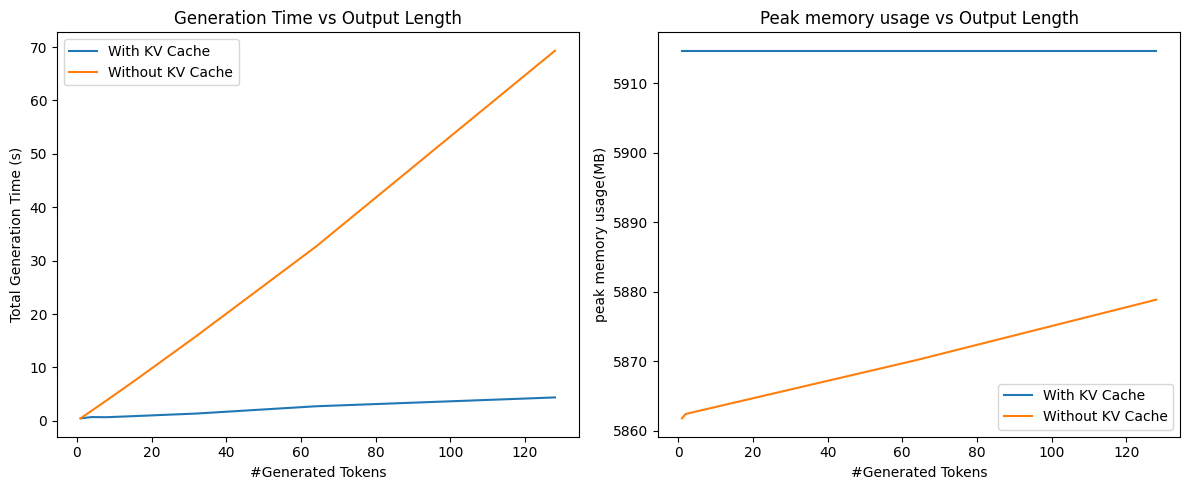


Hint:
Use synthetic data for benchmark. To toggle K-V caching, set the use_cache parameter in the model.generate() function.

In [ ]:
# your code begins

# your code ends